# 1. Problem Statement

We need to model a NN that can classify whether a given image is Building, Forest or Glacier.

We are using dataset imorted from Kaggle titled (Intel Image Classification - 6 class dataset).
<br>I've only used 3 class dataset here for reducing the compute duration.

# 2. Importing libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from random import randint
import cv2 as cv
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import *

# 3. Getting Dataset

### Example of using os library

In [2]:
os.listdir('seg_train')

['buildings', 'forest', 'glacier']

In [3]:
d = 'seg_train'
l = 'buildings'
os.listdir(d+r'/'+l)[:10]   # string literal -> not a escape char.

['0.jpg',
 '10006.jpg',
 '1001.jpg',
 '10014.jpg',
 '10018.jpg',
 '10029.jpg',
 '10032.jpg',
 '10056.jpg',
 '1009.jpg',
 '10113.jpg']

### Function to get the dataset from computer and shuffling

In [4]:
def get_images(directory):
    Images = []
    Labels = []
    
    label = 0
    
    for labels in os.listdir(directory):
        if labels == 'glacier':
            label = 2
        if labels == 'sea':
            label = 4
        if labels == 'buildings':
            label = 0
        if labels == 'forest':
            label = 1
        if labels == 'street':
            label = 5
        if labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+r'/'+labels):
            image = cv.imread(directory+r'/'+labels+r'/'+image_file)
            image = cv.resize(image, (150, 150))
            
            Images.append(image)
            Labels.append(label)
    return shuffle(Images,Labels, random_state = 128)

In [5]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest',
             5:'street', 3:'mountain'}
    return labels[class_code]

### Checking the shuffle function using an example

In [6]:
mylist = [10, 11, 12, 13]
a = [0,1,2,3]
shuffle(mylist, a)

[[12, 13, 11, 10], [2, 3, 1, 0]]

In [7]:
Images, Labels = get_images('seg_train')

# 4. Visualizing the dataset

In [8]:
type(Images)

list

**The Image and Labels have datatype as list.**

as shown below:

In [9]:
print(np.array(Images).shape)
print(np.array(Labels).shape)

(6866, 150, 150, 3)
(6866,)


In [10]:
Images = np.array(Images)
Labels = np.array(Labels)

### Visualizing some examples of training set

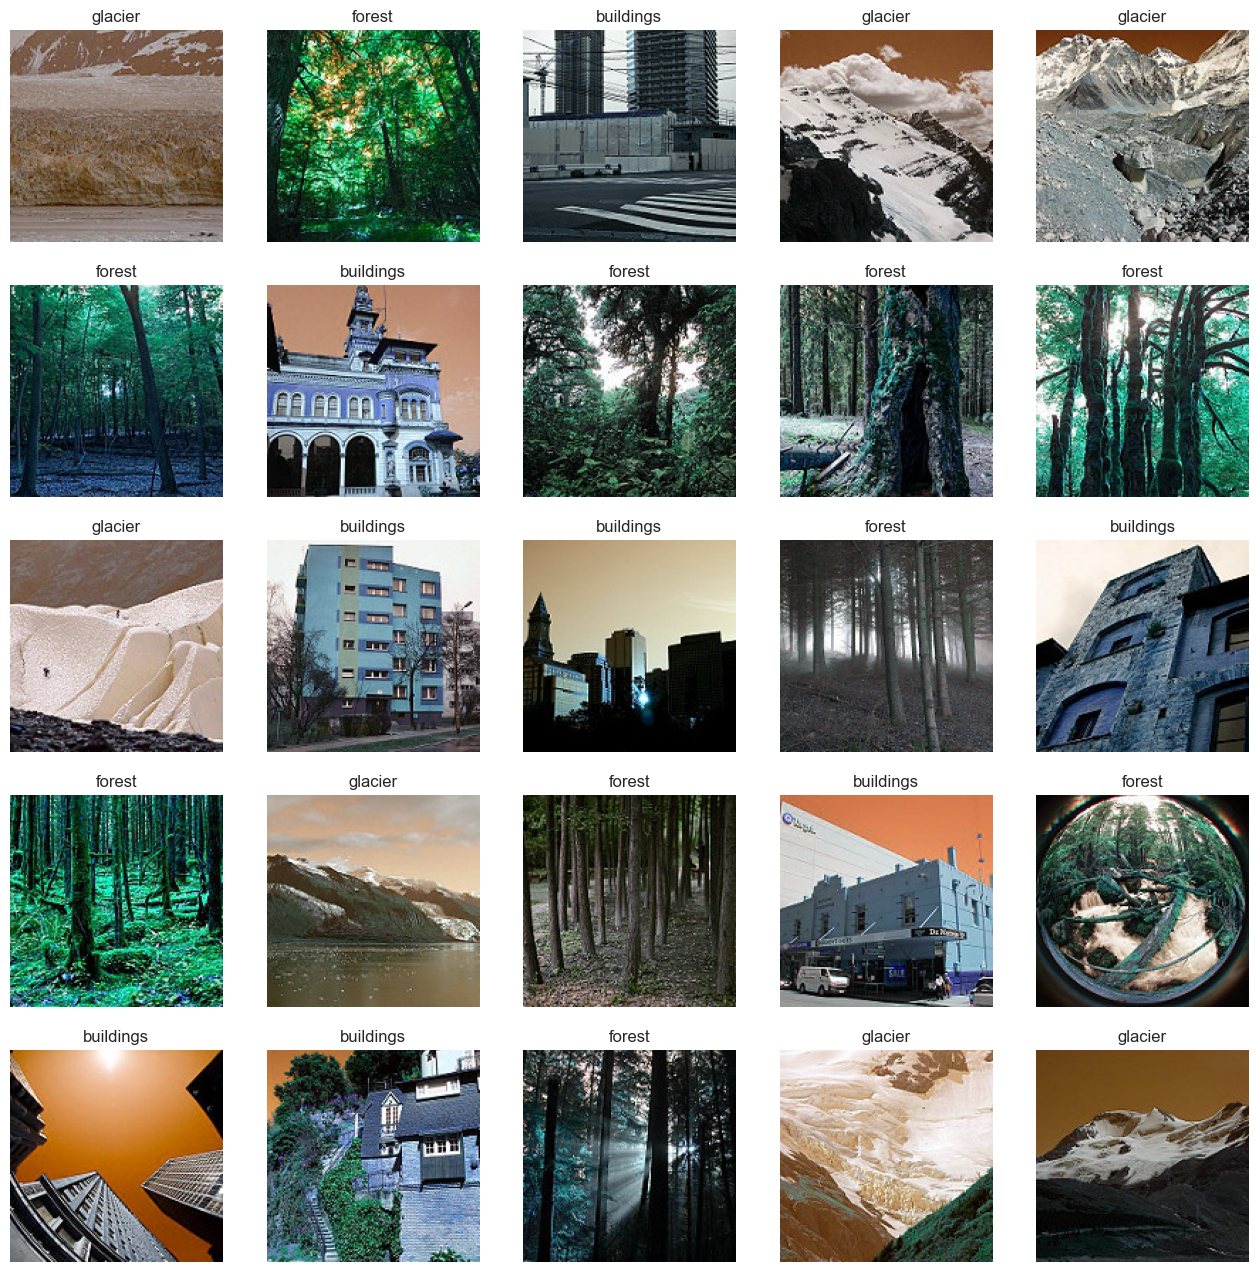

In [11]:
fig , ax = plt.subplots(5, 5, figsize = (16,16))
for i in range(5):
    for j in range(5):
        rnd_number = randint(0, len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i, j].axis('off')

# 5. Modeling

In [12]:
lam = 0.0003
model = tf.keras.Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (150,150,3)))
model.add(layers.Conv2D(8,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(16,kernel_size=(3,3), activation = 'relu', 
                       kernel_regularizer=tf.keras.regularizers.L2(lam)))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(lam)))
model.add(layers.Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(Images,Labels,
          epochs=100,
          validation_split=0.2,
          callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
          verbose = 1)

Epoch 1/100
172/172 [==============================] - 24s 141ms/step - loss: 0.5753 - accuracy: 0.7961 - val_loss: 0.3080 - val_accuracy: 0.9185
Epoch 2/100
172/172 [==============================] - 24s 140ms/step - loss: 0.3031 - accuracy: 0.9091 - val_loss: 0.2914 - val_accuracy: 0.9112
Epoch 3/100
172/172 [==============================] - 25s 144ms/step - loss: 0.2467 - accuracy: 0.9306 - val_loss: 0.2460 - val_accuracy: 0.9323
Epoch 4/100
172/172 [==============================] - 26s 149ms/step - loss: 0.1949 - accuracy: 0.9505 - val_loss: 0.2645 - val_accuracy: 0.9381
Epoch 5/100
172/172 [==============================] - 24s 140ms/step - loss: 0.1665 - accuracy: 0.9610 - val_loss: 0.2060 - val_accuracy: 0.9527
Epoch 6/100
172/172 [==============================] - 24s 142ms/step - loss: 0.1377 - accuracy: 0.9745 - val_loss: 0.1938 - val_accuracy: 0.9563
Epoch 7/100
172/172 [==============================] - 24s 141ms/step - loss: 0.1300 - accuracy: 0.9760 - val_loss: 0.2417 -

**Check for Overfitting**

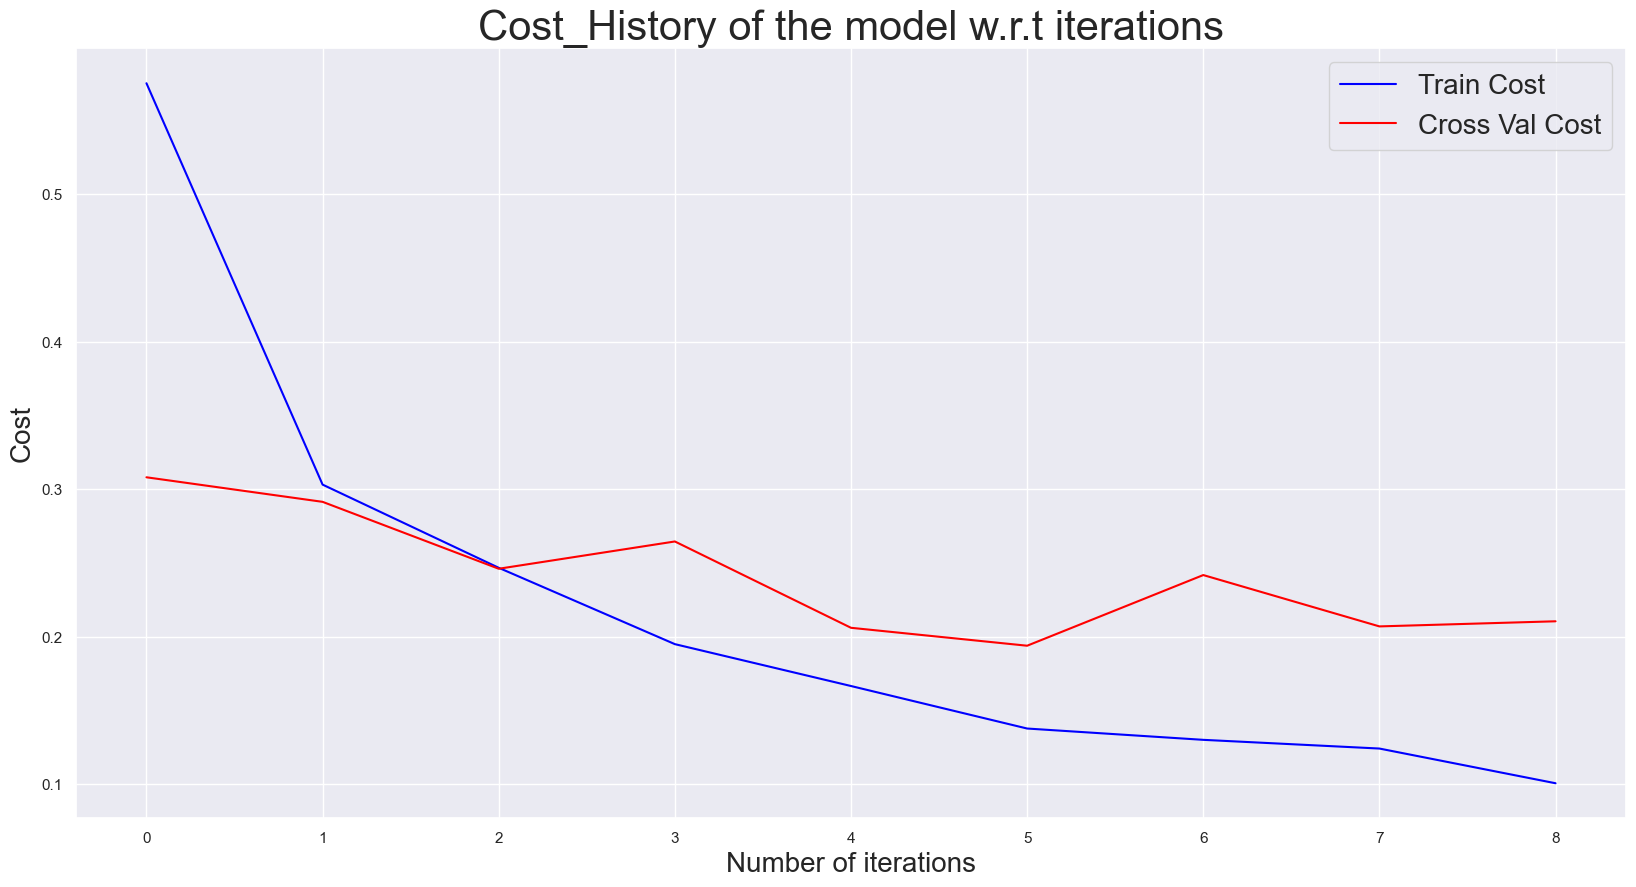

In [14]:
fig, ax = plt.subplots(figsize = (20,10))
ax = plt.plot(model.history.history['loss'], color = 'Blue')
ax = plt.plot(model.history.history['val_loss'], color = 'red')
plt.title('Cost_History of the model w.r.t iterations', fontsize = 30)
plt.xlabel('Number of iterations', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.legend(['Train Cost', 'Cross Val Cost'], fontsize = 20)
plt.show()

# 6. Accuracy 

**(using Test dataset)**

In [15]:
test_images,test_labels = get_images('seg_test')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

46/46 [==============================] - 2s 40ms/step - loss: 0.2214 - accuracy: 0.9529


[0.22136308252811432, 0.9528688788414001]